# Streamgraph Twitter
This notebook takes you through making a streamgraph from tweets contained in a .csv file.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.   

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes). 


- **nltk:** A leading platform for building Python programs to work with human language data.
- **string:** Contains a number of functions to process standard Python strings.
- **re:** Provides regular expression matching operations similar to those found in Perl.
- **os:** Provides a portable way of using operating system dependent functionality.
- **csv:** Implements classes to read and write tabular data in CSV format.
- **math:** Provides access to the mathematical functions defined by the C standard.
- **numpy:** The fundamental package for scientific computing with Python.
- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **scipy:** Open-source software for mathematics, science, and engineering. The SciPy library depends on NumPy, which provides convenient and fast N-dimensional array manipulation.
- **ggplot:** a Python implementation of the grammar of graphics.

In [1]:
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import re
import os
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rankdata
from ggplot import *

### Functions
We need to create functions in order to calculate and create a streamgraph. Any time you see 'def' (without the quotes) that means we are DEclaring a Function. The 'def' is usually followed by the name of the function being created and then in parentheses are the arguments the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed or in other words what the function is doing. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required arguments in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Tweet cleaning and reading

This function is looking for ASCII characters which is a type of text encoding (like utf-8). Will most likely not be making changes to this function.

In [2]:
"""
Check if a token has all ASCII characters
"""
def isAsciiToken(token):
    
    return all(ord(c) < 128 for c in token)

This function removes a character if it is not an ASCII character. This eliminates possible encoding errors later, which happens a lot with social media due to the prevalent use of emojis. Also unlikely to need changing.

In [3]:
"""
Remove non-ascii tokens
"""
def removeNonAsciiToken(tokens):
    
    # remove non-ascii tokens
    tokens = [x for x in tokens if isAsciiToken(x)]
    
    return tokens

This function reads in a .csv file. No changes should be needed here.

In [4]:
def readCSV(filepath, textColIndex, encoding = 'utf-8'):
    
    with open(filepath, encoding = encoding) as f:
        
        reader = csv.reader(f, delimiter = ',', quotechar = '"')
        
        content = []
        for row in reader: 
            content.append(row[textColIndex])
         
        # skip header
        return content[1 : ]

This function removes urls from the tweets using a regular expression (regex). If you are interested in the urls then you may want to skip this function.

In [5]:
"""
Remove URLs
"""
def removeURL(tokens):
    
    p = re.compile(r'^https?://.*$')
    
    tokens = [t for t in tokens if re.match(p, t) is None]
    
    return tokens 

This function removes punctuation and is used as part of the text cleaning function

In [6]:
def allPuncChar(token):
    
    for c in token:
        
        if c not in string.punctuation:
            return False
        
    return True

Now we come to the text cleaning function. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. 

Then we remove stopwords. If you wish to use a stopword list of a language other than English, simply replace 'english' (with the quotes this time) in the cell below with the anglicized name of your language of interest (meaning 'spanish' instead of 'espanol' and 'german' instead of 'deutsch'). There is a limit to the languages available using NLTK's stopwords. The list of available languages can be found by running the code: 'stopwords.fileids()' (without the quotes).

Lastly we remove punctuation, numbers, urls, and non-ascii characters and return a list of cleaned words.

In [7]:
def clean(words, customStopWordsList = None):
    ################
    # cleanup
    ################

    # to lower case
    words = [w.lower() for w in words]


    # remove stop words

    # step 1: custom list
  
    if customStopWordsList is not None:
        words = [w for w in words if w not in customStopWordsList]


    # step 2: built in list
    builtinList = set(stopwords.words('english')) # convert from list to set for fast lookup
    words = [w for w in words if w not in builtinList]

    # remove punctuations
    words = [w for w in words if not allPuncChar(w)]


    # remove numbers
    words = [w for w in words if not w.isnumeric()]
    
    # remove urls
    words = removeURL(words)
    
    # remove non ascii tokens
    words = removeNonAsciiToken(words)
        
    return words

### Read in the tweets

Here we read in the tweets and break them up into chunks of a specified number of tweets. The first two lines, the textColIndex line, and the numTweetsPerBlock line are where you are going to make your changes. 

The first line assigns the file path to the directory where your .csv file is stored and is assigned to the variable 'root'. 

The next line points to the file itself by name and is assigned to the variable 'tweetFile'. 

The textColIndex line is where you point to the column in your .csv file that contains the actual text of the tweets. Right now we have it set for the 3rd column, which is 2 in Python since Python starts counting at 0. So, the first column is 0, the second column is 1, and the third column is 2. Set this number to the what ever column in from the left contains your tweets. 

The numTweetsPerBlock line is where you decide how many tweets you want per chunk. We have it set at 1000, but if you only have 500 tweets, you'll want to change this number. 

These four lines are the only ones you will most likely need to change.

In [8]:
root = '/N/u/klosteda/Carbonate/Text-Analysis/data/twitter'

tweetFile = 'neverAgain.csv'

filepath = os.path.join(root, tweetFile)

textColIndex = 2
encoding = 'ISO-8859-1'

tweets = readCSV(filepath, textColIndex, encoding)

print('Read {} tweets'.format(len(tweets)))

numTweetsPerBlock = 1000

numberBlocks = int(math.ceil(len(tweets) / numTweetsPerBlock))

print('Tweets per block: {}, # blocks is {}'.format(numTweetsPerBlock, numberBlocks))

blocks = []

for i in range(numberBlocks - 1):
    
    blocks.append(tweets[i * numTweetsPerBlock : (i + 1) * numTweetsPerBlock])
    
blocks.append(tweets[(i + 1) * numTweetsPerBlock : ])

Read 50645 tweets
Tweets per block: 1000, # blocks is 51


### Load in custom stopwords

There are two places to make adjustments in this block. First, you will want to change the filepath to point to your own personal custom stopword list. The second place to make changes is where it says lines.extend. The words in quotes in the brackets are words being added to the stopword list. Simply add words you want removed in quotes and separated by a comma. The rest will most likely not need to be changed.

In [9]:
# load custom stop words list
filepath = "/N/u/klosteda/Carbonate/Text-Analysis/data/earlyModernStopword.txt"

with open(filepath) as f:
    lines = f.read().splitlines()

lines = [l.strip() for l in lines]
lines.extend(['amp','rt', 'dont'])

customStopWordsList = set(lines) # convert from list to set for fast lookup

tokenBlocks = []

for b in blocks:
    
    text = ' '.join(b)
    
    tokens = word_tokenize(text)
    
    tokenBlocks.append(clean(tokens, customStopWordsList))
    

### Pick words of interest
Here we decide what words we are most interested in seeing in the streamgraph. Just add any words with quotes and separated by a comma. There is no limit to how many words you can look at. However, at some point the graph may become difficult to read if you put too many words, so keep that in mind.

In [10]:
# calculate frequency

interestedWords = ['nra', 'gop', 'msdstrong']

freqDict = {}

for w in interestedWords:
    
    freqDict[w] = np.zeros(len(tokenBlocks)).tolist()
    
for idx, block in enumerate(tokenBlocks):
    
    for token in block:
        
        if token in freqDict:
            freqDict[token][idx] += 1

### Emulate R's stat_steamgraph in 'ggTimeSeries' package

This function is meant to emulate the stat_steamgraph function from the ggTimeSeries package in R. You will most likely not need to make any changes here. This function is creating a special data frame (kind of like an excel table) for ggplot to be able to read it in a way that it creates a streamgraph from the data.

In [11]:
def composeDataframe(freqDict, debug = False):

    if debug:
        df = pd.DataFrame(data = freqDict)
        print(df)
        print('\n' * 3)


    wordCol = []
    freqCol = []
    seqNum = []
    
    for word in freqDict:
        wordCol.extend([word] * len(freqDict[word]))
        freqCol.extend(freqDict[word])
        seqNum.extend(list(range(1, len(freqDict[word]) + 1)))

    dataDict = {"Term" : wordCol, "Freq" : freqCol, 'SeqNum' : seqNum}

    df = pd.DataFrame(data = dataDict)

    if debug:
        print(df)
        print('\n' * 3)

    rankdf = df.groupby(["Term"], as_index = False).agg({"Freq" : "std"}).rename(columns = {"Freq" : "Std"})

    if debug:
        print(df)
        print('\n' * 3)

    rankdf["StdRank"] = rankdata(rankdf["Std"], method = 'ordinal')

    if debug:
        print(rankdf)
        print('\n' * 3)

    for idx, row in rankdf.iterrows():

        if row["StdRank"] % 2 == 0:
            rankdf.at[idx, "StdRank"] = -row["StdRank"]


    if debug:
        print(rankdf)
        print('\n' * 3)

    df = df.merge(rankdf, on = 'Term')

    if debug:
        print(df)
        print('\n' * 3)

    df = df.sort_values(by = ['SeqNum', 'StdRank'])

    if debug:
        print(df)
        print('\n' * 3)

    def f(x):

        x["cumsum"] = x["Freq"].cumsum()
        x["ymax"] = x["Freq"].cumsum() - x["Freq"].sum() / 2
        x["ymin"] = x["ymax"] - x["Freq"]

        return x


    df = df.groupby(["SeqNum"], as_index = False).apply(f)

    if debug:
        print(df)
        print('\n' * 3)
        
    return df


Now we apply the emulator data frame function from above to our corpus so we can plot the streamgraph in our next block of code. Again, it is unlikely that you will need to make changes here.

In [12]:
df = composeDataframe(freqDict)

### Plot the Streamgraph

For the code below, you will only need to make changes to five lines of code. The first is where it says 'scale_fill_brewer'. You may want to change the palette color to something else besides 'Dark2' (with the quotes). Some color options can be found [here](https://www.nceas.ucsb.edu/~frazier/RSpatialGuides/colorPaletteCheatsheet.pdf) under RColorBrewer. Next you will want to change the xlab, ylab, and ggtitle lines to match your data. The xlab and ylab is where you can change the labels of the x and y axis. The size changes the font size and vjust changes the distance from the graph the label appears. Finally, you will want to change the file path in plt.savefig to match where you want a .png of the graph to be saved and what you want to name the file. Once you've made your changes, you're ready to plot your graph!

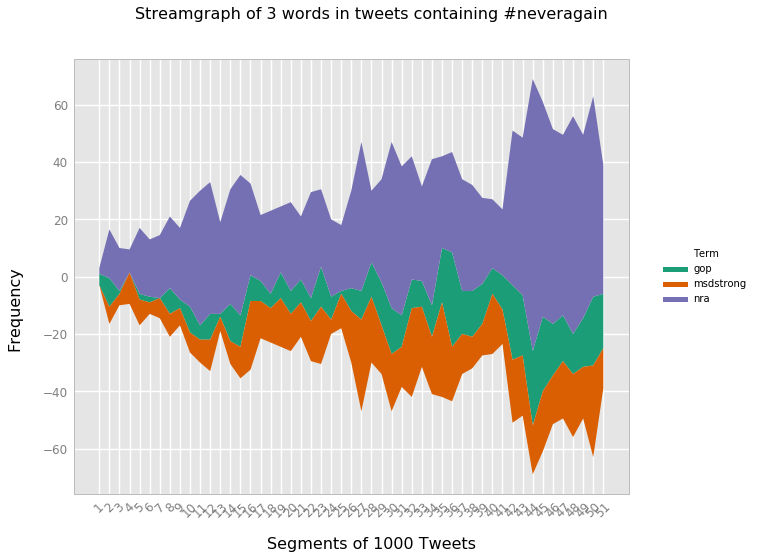

In [14]:
p = ggplot(df, aes(x = 'SeqNum', ymin = 'ymin', ymax = 'ymax', y = 'Freq', group = 'Term', fill = 'Term')) +\
    geom_ribbon() + \
    theme(axis_text_x = element_text(angle = 45, hjust = 1)) + \
    scale_fill_brewer(type = 'qual', palette = 'Dark2') + \
    xlab(element_text(text = "Segments of 1000 Tweets", size = 16, vjust = -0.02)) + \
    ylab(element_text(text = "Frequency", size = 16)) + \
    scale_x_continuous(breaks = list(range(1, len(tokenBlocks) + 1))) + \
    ggtitle(element_text(text = "Streamgraph of 3 words in tweets containing #neveragain", size = 16))
p.make()
plt.savefig("/N/u/klosteda/Carbonate/Text-Analysis/Output/streamgraphNeverAgainPy.png", width = 14, height = 8, dpi = 800)

plt.show()

## VOILA!!